In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

import itertools
import numpy as np
import choix
import math

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm
from joblib import Parallel, delayed


In [3]:
# round design variables

# design the distribution of expertise for voters
# the approach here is to use the beta-distribution as a way to generate a distribution of expertise,
#  with several parameters mapping to low, medium, and high expertise
# We then draw from this distribution to assign expertise to each voter
expertise2params = {
    'very-low': (1, 6),
    'low': (1, 3),
    'medium': (3, 3),
    'high': (3, 1),
    'very-high': (6, 1),
    'const-0.5': (0.5,),
    'const-0.75': (0.75,),
    'const-1.0': (1.0,),
}

# similar to the above, define a distribution of project impact.
impact2params = {
    'low': (1, 4),
    'medium': (2, 2),
    'high': (4, 1),
    'random': (1, 1),
    'u-shaped': (0.5, 0.5)
}

laziness2params = {
    'low': (1, 3),
    'medium': (3, 3),
    'high': (3, 1),
    'const-0.0': (0.0,),
    'const-0.5': (0.5,),
    'const-0.75': (0.75,),
    'const-1.0': (1.0,),
}

In [4]:
# a metric used for comparing the inferred ranking to the actual ranking
def min_swaps_to_sort(arr1, arr2):
    n = len(arr1)
    # Create a map of value to its index in arr1
    index_map = {value: i for i, value in enumerate(arr1)}

    visited = [False] * n
    swaps = 0

    for i in range(n):
        if visited[i] or arr1[i] == arr2[i]:
            continue

        cycle_size = 0
        x = i

        while not visited[x]:
            visited[x] = True
            x = index_map[arr2[x]]
            cycle_size += 1

        if cycle_size > 0:
            swaps += (cycle_size - 1)

    return swaps

def run_single_simulation(
        n_badgeholders=50, 
        badgeholder_expertise_distribution=None,  # a vector input that should be len==#badgeholders
        badgeholder_voting_style='skewed_towards_impact',
        badgeholder_laziness_distribution=None,   # a vector input that should be len==#badgeholders
        n_projects=20, 
        project_impact_distribution=None,         # a vector input that should be len==#projects
        badgeholder_coi_mappings=None,  # a dictionary of badgeholder_id to project_id that is COI
        random_seed=1234
    ):
    assert badgeholder_expertise_distribution is not None
    assert badgeholder_laziness_distribution is not None
    assert project_impact_distribution is not None
    assert len(badgeholder_expertise_distribution) == n_badgeholders
    assert len(badgeholder_laziness_distribution) == n_badgeholders
    assert len(project_impact_distribution) == n_projects

    rng = np.random.default_rng(random_seed)

    if badgeholder_coi_mappings is None:
        badgeholder_coi_mappings = {}
    # this loop error checking assumes that badgeholderIds and projectIds are 0-indexed
    for badgeholder_id, project_ids in badgeholder_coi_mappings.items():
        if badgeholder_id >= n_badgeholders:
            raise ValueError('COI badgeholder_id must be less than n_badgeholders')
        for project_id in project_ids:
            if project_id >= n_projects:
                raise ValueError('COI project_id must be less than n_projects')
    
    # get a list of all the projects that will be voted via COI
    coi_projects_list = []
    for badgeholder_id, project_ids in badgeholder_coi_mappings.items():
        coi_projects_list.extend(project_ids)

    # create badgeholders
    badgeholder_list = []
    for ii in range(n_badgeholders):
        badgeholder_id = ii
        expertise = badgeholder_expertise_distribution[ii]
        laziness = badgeholder_laziness_distribution[ii]
        
        if badgeholder_id in badgeholder_coi_mappings:
            coi_project_ids = badgeholder_coi_mappings[badgeholder_id]
            engaging_in_coi = True
            # print(f'Badgeholder {badgeholder_id} is engaging in COI with projects: {coi_project_ids}')
        else:
            coi_project_ids = []
            engaging_in_coi = False
        agent = PairwiseBadgeholder(
            badgeholder_id=badgeholder_id,
            voting_style=badgeholder_voting_style,
            expertise=expertise,
            laziness=laziness,
            coi_projects=coi_project_ids,
            engaging_in_coi=engaging_in_coi,
        )
        badgeholder_list.append(agent)
    badgeholders = PairwiseBadgeholderPopulation()
    badgeholders.add_badgeholders(badgeholder_list)

    # create projects
    projects = []
    for ii in range(n_projects):
        project_id = ii
        project_impact = project_impact_distribution[ii]
        project = Project(
            project_id=project_id,
            true_impact=project_impact,  
            owner_id=None,  # used for COI modeling
        )
        projects.append(project)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # this is a no-op currently, but can change in the future
    fund_distribution_model = PairwiseBinary()

    # create and run a simulation
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )

    # voters can vote on all projects, but an individual badgeholder can decide to ignore
    # some, based on the badgeholder configuration
    voting_view_ix = list(itertools.combinations(range(project_population.num_projects), 2))  # we need a list since we use this twice
    voting_view = []
    for ix1, ix2 in voting_view_ix:
        voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
    simulation_obj.run(cast_votes_kwargs={'view': voting_view})

    # store the project impact differences
    impact_diff_vec = []
    for ix1, ix2 in voting_view_ix:
        p1 = project_population.get_project(ix1)
        p2 = project_population.get_project(ix2)
        impact_diff_vec.append(p1.true_impact - p2.true_impact)

    # make a matrix of all the pairwise voting possibilities
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_list = simulation_obj.projects.projects
    N = len(project_list)
    project_vote_matrix = np.zeros((N, N))
    project2ix = {p:ix for ix, p in enumerate(project_list)}
    vote_data_list = []

    # put the votes into the matrix for analysis
    for v in all_votes:
        ix1 = project2ix[v.project1]
        ix2 = project2ix[v.project2]
        project_vote_matrix[ix1, ix2] += v.val1
        project_vote_matrix[ix2, ix1] += v.val2

        if v.val1 > v.val2:
            vote_data_list.append((ix1, ix2))
        elif v.val2 > v.val1:
            vote_data_list.append((ix2, ix1))
        else:
            # TODO: not sure if there is a tie, is that even possible??
            print('In Tie scenario!')
            pass

    # estimate parameters of bradley terry model - TODO: update to MCMC estimation
    try:
        params = choix.ilsr_pairwise(N, vote_data_list)  
    except ValueError:
        params = choix.ilsr_pairwise(N, vote_data_list, alpha=0.01)
    # create rank order of project ids
    project_ix_worst_to_best_inferred = np.argsort(params)
    project_ix_best_to_worst_inferred = project_ix_worst_to_best_inferred[::-1]

    # compare the inferred ranks to the actual ranks
    actual_project_impacts = np.array([p.true_impact for p in project_list])
    # rank them
    project_ix_worst_to_best_actual = np.argsort(actual_project_impacts)
    project_ix_best_to_worst_actual = project_ix_worst_to_best_actual[::-1]

    # # compare the two
    # print('Actual Project Ranking by impact:', project_ix_worst_to_best_actual)
    # print('Inferred Project Ranking by impact:', project_ix_worst_to_best_inferred)

    min_swaps = min_swaps_to_sort(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred)
    tau = stats.kendalltau(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred).correlation

    return min_swaps, tau, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred

def run_n_simulations(
    n_sims,
    n_badgeholders, 
    badgeholder_expertise_distribution,
    badgeholder_voting_style,
    badgeholder_laziness_distribution,
    n_projects, 
    project_impact_distribution,
    badgeholder_coi_mappings,
    random_seed_start=1234,
    n_jobs=-1  # Number of parallel jobs (-1 means using all processors)
):
    def run_simulation(ii):
        seed = random_seed_start + ii
        min_swaps, ktau, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred = run_single_simulation(
            n_badgeholders=n_badgeholders, 
            badgeholder_expertise_distribution=badgeholder_expertise_distribution,
            badgeholder_voting_style=badgeholder_voting_style,
            badgeholder_laziness_distribution=badgeholder_laziness_distribution,
            n_projects=n_projects, 
            project_impact_distribution=project_impact_distribution,
            badgeholder_coi_mappings=badgeholder_coi_mappings,
            random_seed=seed
        )
        return min_swaps, ktau, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred

    results = Parallel(n_jobs=n_jobs)(delayed(run_simulation)(ii) for ii in tqdm(range(n_sims)))
    # results = []
    # for ii in tqdm(range(n_sims)):
    #     results.append(run_simulation(ii))
    
    min_swaps_list, ktau_list, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred = zip(*results)
    min_swaps_list = np.array(min_swaps_list)
    ktau_list = np.array(ktau_list)
    impact_diff_vec = np.array(impact_diff_vec)
    project_ix_worst_to_best_actual = np.array(project_ix_worst_to_best_actual)
    project_ix_worst_to_best_inferred = np.array(project_ix_worst_to_best_inferred)

    return {
        'min_swaps_list': min_swaps_list,
        'ktau_list': ktau_list,
        'impact_diff_vec': impact_diff_vec,
        'project_ix_worst_to_best_actual': project_ix_worst_to_best_actual,
        'project_ix_worst_to_best_inferred': project_ix_worst_to_best_inferred
    }

In [8]:
num_mc = 32
n_badgeholders = 30
n_projects = 100
badgeholder_voting_style = 'skewed_towards_impact'

# set these directly so we can more directly measuer the impact of COI
project_impact_distribution = np.linspace(0.1, 0.9, n_projects)
badgeholder_expertise_distribution = np.ones(n_badgeholders) * 0.5  
badgeholder_laziness_distribution = np.ones(n_badgeholders) * 0.0

coi_project_ix = 25
badgeholder_coi_mapping = {
    0: [coi_project_ix],
}

sim_results_with_coi = run_n_simulations(
    num_mc,
    n_badgeholders=n_badgeholders, 
    badgeholder_expertise_distribution=badgeholder_expertise_distribution,
    badgeholder_voting_style=badgeholder_voting_style,
    badgeholder_laziness_distribution=badgeholder_laziness_distribution,
    n_projects=n_projects, 
    project_impact_distribution=project_impact_distribution,
    badgeholder_coi_mappings=badgeholder_coi_mapping,
    random_seed_start=1234,
    n_jobs=-1
)
sim_results_without_coi = run_n_simulations(
    num_mc,
    n_badgeholders=n_badgeholders, 
    badgeholder_expertise_distribution=badgeholder_expertise_distribution,
    badgeholder_voting_style=badgeholder_voting_style,
    badgeholder_laziness_distribution=badgeholder_laziness_distribution,
    n_projects=n_projects, 
    project_impact_distribution=project_impact_distribution,
    badgeholder_coi_mappings=None,
    random_seed_start=1234,  # same seed to make results directly comparable
    n_jobs=-1
)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

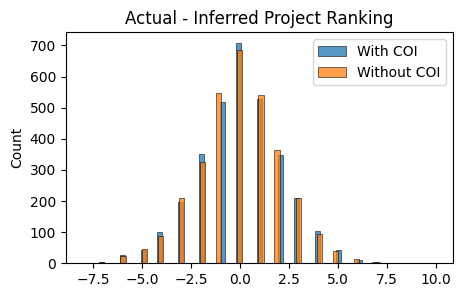

In [9]:
# this is for the whole population
actual_minus_inferred_with_coi = sim_results_with_coi['project_ix_worst_to_best_actual'] - sim_results_with_coi['project_ix_worst_to_best_inferred']
actual_minus_inferred_without_coi = sim_results_without_coi['project_ix_worst_to_best_actual'] - sim_results_without_coi['project_ix_worst_to_best_inferred']

# actual_minus_inferred_with_coi
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.histplot(actual_minus_inferred_with_coi.flatten(), ax=ax, label='With COI')
sns.histplot(actual_minus_inferred_without_coi.flatten(), ax=ax, label='Without COI')
ax.set_title('Actual - Inferred Project Ranking')
ax.legend()

[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25]
[29 31 29 30 32 27 35 26 28 30 29 28 28 26 29 28 26 30 31 31 30 29 27 30
 29 27 30 33 32 31 28 28]
[25 25 26 27 26 26 24 31 22 26 25 20 26 24 24 24 25 29 27 24 21 24 30 28
 27 25 22 21 26 25 25 29]


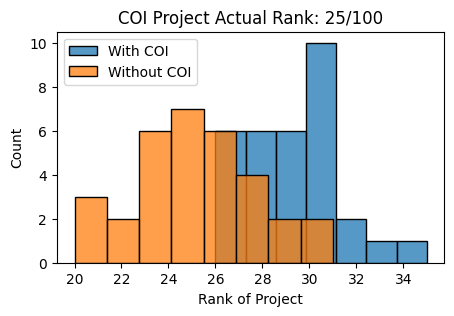

In [10]:
# we can also check how COI affected the specific project that was in COI
actual_ix = np.where(sim_results_with_coi['project_ix_worst_to_best_actual'] == coi_project_ix)
inferred_ix_with_coi = np.where(sim_results_with_coi['project_ix_worst_to_best_inferred'] == coi_project_ix)
inferred_ix_without_coi = np.where(sim_results_without_coi['project_ix_worst_to_best_inferred'] == coi_project_ix)
print(actual_ix[1])
print(inferred_ix_with_coi[1])
print(inferred_ix_without_coi[1])

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.histplot(inferred_ix_with_coi[1], ax=ax, label='With COI')
sns.histplot(inferred_ix_without_coi[1], ax=ax, label='Without COI')
# ax.set_title('Actual - Inferred Project Ranking')
ax.set_xlabel('Rank of Project')
ax.set_title(f'COI Project Actual Rank: {coi_project_ix}/{n_projects}')
ax.legend()